Las cuatro redes de proteínas de levadura que
disponemos: Y2H, AP-MS, LIT y Lit-Reguly. Las dos últimas son redes construidas a partir de
interacciones reportadas en la literatura. 

In [60]:
#librerias a utilizar
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as scipy

In [61]:
#Para abrir archivos
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    if os.path.basename(nombre_archivo) == 'yeast_LIT_Reguly.txt':
        data = data[1:]
        enlaces = []
        for linea in data:
            enlaces.append(linea[:2])
        return(enlaces)
    if os.path.basename(nombre_archivo) == 'Essential_ORFs_paperHe.txt': 
        data = data[2:]
        esenciales = []
        for linea in data:
            if len(linea)>2:
                esenciales.append(linea[1])
        return esenciales
    else:
        return data

def crear_redes(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    return Red

In [62]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'AP_MS': './data/yeast_AP-MS.txt',
         'Lit': './data/yeast_LIT.txt',
         'Lit_reg': "./data/yeast_LIT_Reguly.txt"
         }
redes_dict = {}

for red in redes:
    grafo = crear_redes(redes[red])
    redes_dict[red] = {}
    redes_dict[red]["Grafo"] = grafo

# Tabla 1

In [63]:
def get_red_info(nombre_red):
    
    red = redes_dict[nombre_red]
    grafo = red['Grafo']
    red['Nodos'] = grafo.number_of_nodes() 
    red['Enlaces'] = grafo.number_of_edges()
    red['Grado medio'] = 2 * red['Enlaces'] / red['Nodos']
    red['Clustering medio'] = nx.average_clustering(grafo)   

In [64]:
for red in redes_dict.keys():
    get_red_info(red)

In [65]:
import pandas as pd

redes_df = redes_dict.copy() #no modificar data
df = pd.DataFrame(redes_dict).transpose()
df_sin_grafo = df.drop(columns = ['Grafo'])
df_sin_grafo = df_sin_grafo.astype({'Clustering medio': float, 'Grado medio': float})
df_sin_grafo.round({'Clustering medio': 2, 'Grado medio': 2})

,Clustering medio,Enlaces,Grado medio,Nodos
Y2H,0.05,2930,2.90,2018
AP_MS,0.55,9070,11.18,1622
Lit,0.29,2925,3.81,1536
Lit_reg,0.26,11858,7.17,3307


# Tabla 2

In [66]:
nodos = {}
enlaces = {}

for red in redes_dict:
    Red_proteinas = redes_dict[red]['Grafo']
    #Guardo enlaces y nodos en un set para poder hacer comparaciones facilmente
    enlaces[red], nodos[red] = set(), set()
    for nodo in Red_proteinas.nodes(): nodos[red].add(nodo)
    #Como los enlaces son NO dirigidos, los ordeno los nodos del enlace antes de guardarlo
    for enlace in Red_proteinas.edges(): enlace=sorted(enlace);enlaces[red].add((enlace[0],enlace[1]))

In [67]:
overlap_dict = {}  
lista_redes = list(redes_dict.keys())
lista_redes

['Y2H', 'AP_MS', 'Lit', 'Lit_reg']

In [68]:
def intersection(dicts):
    for key in dicts.keys():
        overlap_dict[key] = {}
        overlap_dict[key][key] = 0
        a = dicts[key]
        lista = ('b', 'c', 'd')
        for red in dicts.keys():
            if red == key:
                overlap_dict[key][key] = 0 
            else:
                interseccion = a.intersection(dicts[red])
                overlap_dict[key][red] = len(interseccion) / len(a)
            
                           
intersection(enlaces)     

In [69]:
overlap_dict

{'Y2H': {'Y2H': 0,
  'AP_MS': 0.08873720136518772,
  'Lit': 0.08873720136518772,
  'Lit_reg': 0.163481228668942},
 'AP_MS': {'AP_MS': 0,
  'Y2H': 0.02866593164277839,
  'Lit': 0.14310915104740904,
  'Lit_reg': 0.27783902976846747},
 'Lit': {'Lit': 0,
  'Y2H': 0.08888888888888889,
  'AP_MS': 0.4437606837606838,
  'Lit_reg': 0.9777777777777777},
 'Lit_reg': {'Lit_reg': 0,
  'Y2H': 0.040394670264800134,
  'AP_MS': 0.21251475796930341,
  'Lit': 0.24118738404452691}}

In [70]:
enlaces_df = overlap_dict.copy() #no modificar data
df = pd.DataFrame(enlaces_df).transpose()
df = df.astype(float).round(3)
for red, _ in df.iterrows():
    df.loc[df[red] == 0, red] = '-'
df


,AP_MS,Lit,Lit_reg,Y2H
Y2H,0.089,0.089,0.163,-
AP_MS,-,0.143,0.278,0.029
Lit,0.444,-,0.978,0.089
Lit_reg,0.213,0.241,-,0.04


Esta tabla se lee "De los enlaces de Y2H un 8.9% de sus enlaces también está en AP MS".

Esto no lo pide, pero podriamos ponerlo. Lo mismo una tabla para nodos. 

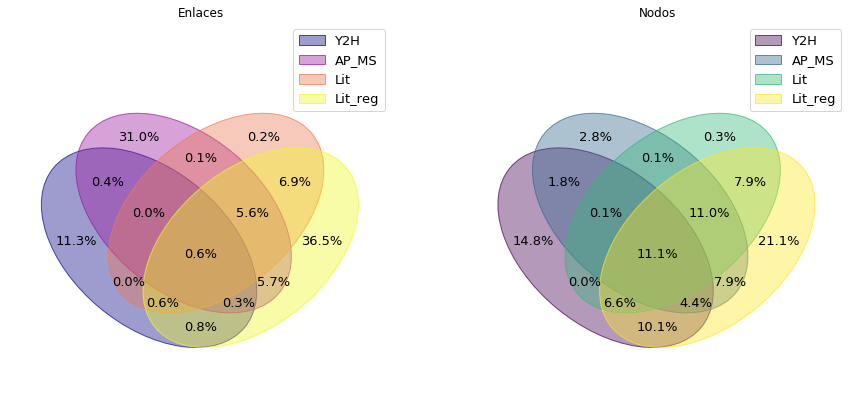

In [71]:
from venn import venn
f, axs = plt.subplots(1, 2 , figsize=(15,15))
venn_e = venn(enlaces, fmt="{percentage:.1f}%", ax= axs[0], cmap = "plasma")
axs[0].set_title("Enlaces")
venn(nodos, fmt="{percentage:.1f}%", ax= axs[1] )
axs[1].set_title("Nodos")
plt.show()

# Figura 1

In [72]:
lista_esenciales = abrir_txt('./data/Essential_ORFs_paperHe.txt')

grados_ordenados = {}

def segundo_lugar(item):
    return item[1]

for red in redes_dict.keys():
    grados_lista = list(redes_dict[red]['Grafo'].degree())
    grados_lista.sort(key = segundo_lugar, reverse = True)
    grados_ordenados[red] = grados_lista

In [73]:
from operator import itemgetter

def calcular_esenciales(red):
    
    nodos = list(map(itemgetter(0), grados_ordenados[red])) #lista de nodos ordenados por grado
    orden_grados = list(map(itemgetter(1), grados_ordenados[red])) #grados de dichos nodos
    
    hub_definition = []
    fraccion_hubs_esenciales = []

    for i in orden_grados: 
        lista_nodos = []
        for j in range(0,len(nodos)):
            if orden_grados[j] >= i: 
                lista_nodos.append(nodos[j]) #solo si tienen mayor grado
        
        hub_definition.append(len(lista_nodos) / redes_dict[red]['Nodos']) #propocion de nodos que tomo como hub
        hubs_esenciales = set(lista_nodos).intersection(lista_esenciales) #nodos esenciales dentro de los hubs
        fraccion_hubs_esenciales.append(len(hubs_esenciales) / len(lista_nodos) ) #fraccion entre los hubs de esenciales       
        
    return hub_definition, fraccion_hubs_esenciales

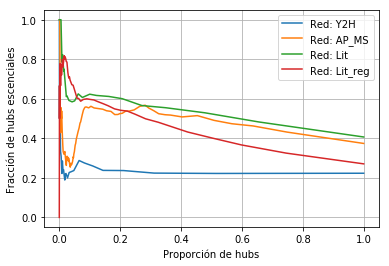

In [74]:
correlaciones = {}
for red in redes_dict.keys():
    x, y = calcular_esenciales(red)
    correlaciones[red] = {}
    correlaciones[red]['Kendall'] = scipy.kendalltau(x,y)[0]
    correlaciones[red]['Kendall p value'] = (scipy.kendalltau(x,y)[1])
    correlaciones[red]['Spearman'] = scipy.spearmanr(x,y)[0]
    correlaciones[red]['Spearman p value'] = scipy.spearmanr(x,y)[1]
    plt.plot(x, y, label = f'Red: {red}')
    plt.xlabel('Proporción de hubs')
    plt.ylabel('Fracción de hubs escenciales')
    plt.legend()
    

plt.grid()
plt.show()

In [75]:
correlaciones_df = correlaciones.copy() #no modificar data
df = pd.DataFrame(correlaciones_df).transpose()
df = df.astype(float).round(3)
df

,Kendall,Kendall p value,Spearman,Spearman p value
Y2H,-0.351,0.0,-0.448,0.0
AP_MS,-0.689,0.0,-0.693,0.0
Lit,-0.971,0.0,-0.994,0.0
Lit_reg,-0.995,0.0,-0.998,0.0


# Figura 3

Esto es igualito al ejercicio 2c del TPC_01.
Tenemos que considerar 7 centralidades:
* Remover nodos esenciales de una
* Random (ver código ya hecho)
* Eigenvalue: diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
* Degree centrality diccionario_centralidad_grado = nx.degree_centrality(Red)
* Shortest path diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
* current_flow 
* diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
*

### 1) Esenciales

In [115]:
def sacar_esenciales(red, lista_esenciales):
    cant_nodos = redes_dict[red]['Nodos']
    Graph = redes_dict[red]['Grafo'].copy() #no modifico originales
    Graph.remove_nodes_from(lista_esenciales)
    fracc_nodos_sacados = 1 - Graph.number_of_nodes() / cant_nodos
      
    
    componentes=[Graph.subgraph(componente)
                 for componente in sorted(nx.connected_components(Graph),
                                          key=len, reverse=True)]
    gigante = componentes[0]
    fracc_tamamo_gigante = gigante.number_of_nodes() / cant_nodos
    return fracc_nodos_sacados, fracc_tamamo_gigante

Esto sólo para saber

In [116]:
nodos_esenciales_frac = {}
for red in redes_dict.keys():
    nodos_esenciales_frac[red] = len(set(redes_dict[red]["Grafo"].nodes()).intersection(lista_esenciales)) / redes_dict[red]['Nodos']

nodos_esenciales_frac

{'Y2H': 0.22348860257680872,
 'AP_MS': 0.37422934648581996,
 'Lit': 0.4069010416666667,
 'Lit_reg': 0.27094042939219837}

Ploteo para ir viendo, pero después hacemos toda una figura

1122
2018
1122
1622
1122
1536
1122
3307


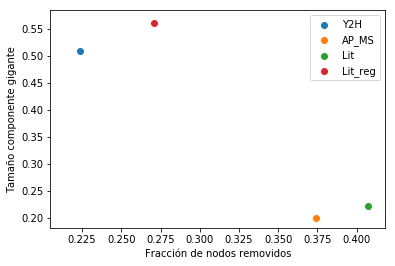

In [117]:
x = {}
y = {}
for red in redes_dict.keys():
    x[red], y[red] = sacar_esenciales(red, lista_esenciales)
    plt.scatter(x[red], y[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 2) Random

In [265]:
def desarme_random(red):
    cant_nodos = redes_dict[red]['Nodos']
    tamano_gigante = np.array([])
    Red_rota_rand = redes_dict[red]['Grafo'].copy()
    nodes = list(Red_rota_rand.nodes)
    
    for node in nodes:
        Red_rota_rand.remove_node(node)
        componentes  = sorted(nx.connected_components(Red_rota_rand), 
                                                   key=len, reverse=True)
        
                        
        if len(componentes) >= 1:
            gigante = Red_rota_rand.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
            
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

In [266]:
import time

times = 2
i = 0
y_rand = {k: np.zeros(shape = redes_dict[k]["Nodos"]) for k in redes_dict.keys()}

while i < times:
    for red in redes_dict.keys():
        start = time.time()
        y_rand[red] = y_rand[red] + desarme_random(red)
        end = time.time()
        print(f'La red {red}_{i} tardó {round(end - start, 2)}s')
    i += 1

La red Y2H_0 tardó 4.71s
La red AP_MS_0 tardó 3.04s
La red Lit_0 tardó 2.72s
La red Lit_reg_0 tardó 14.52s
La red Y2H_1 tardó 4.63s
La red AP_MS_1 tardó 3.15s
La red Lit_1 tardó 2.55s
La red Lit_reg_1 tardó 14.39s


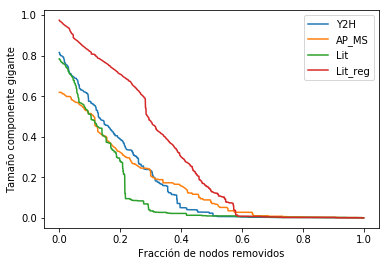

In [267]:
for red in y_rand.keys():
    y = y_rand[red] / times
    cant_nodos = redes_dict[red]['Nodos']
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x,y, label = f'{red}')
    
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 3) Eigenvalue

In [324]:
import operator

def desarme_eigenvalue(red):
    centrality = nx.eigenvector_centrality(redes_dict[red]["Grafo"], max_iter=1000, tol=1e-03)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(centrality.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        centrality = nx.eigenvector_centrality(Red_rota, max_iter=1000, tol=1e-03)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

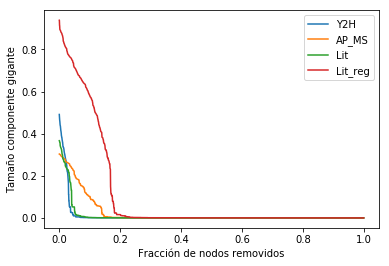

In [325]:
for red in redes_dict.keys():
    y = desarme_eigenvalue(red)
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x, y, label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 4) Degree

In [329]:
import operator

def desarme_degree(red):
    degree = nx.degree_centrality(redes_dict[red]["Grafo"])

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(degree.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        degree = nx.degree_centrality(Red_rota)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

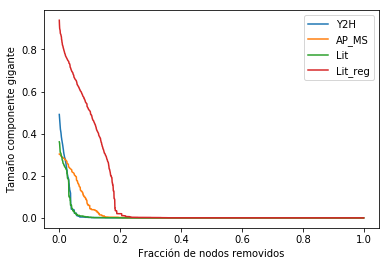

In [330]:
for red in redes_dict.keys():
    y = desarme_degree(red)
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x, y, label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 5) Betweeness

In [449]:
import operator

def desarme_bet(red):
    k = 20
    bet = nx.betweenness_centrality(redes_dict[red]["Grafo"], k = k)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > k:
        node = max(bet.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
       
        bet = nx.betweenness_centrality(Red_rota, k = k)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

La red Y2H tardó 30.99s
La red AP_MS tardó 15.54s
La red Lit tardó 12.95s
La red Lit_reg tardó 126.88s


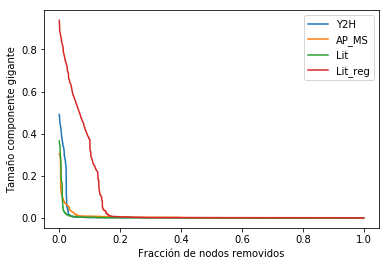

In [450]:
for red in redes_dict.keys():
    start = time.time()
    y = desarme_bet(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x, y, label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 6) Closeness

In [429]:
import igraph as ig

def close_ig(red):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(red.nodes()))
    G_ig.add_edges(list(red.edges()))
    closeness = G_ig.closeness(vertices=None, mode='ALL', cutoff=None, weights=None, normalized=True)
    keys = list(red.nodes())
    close_dict = dict(zip(keys, closeness))
    return close_dict



In [425]:
import operator

def desarme_close(red):
    start = time.time()
    close = close_ig(redes_dict[red]['Grafo'])
       
    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()
    
    i = 0
    size_gigante = redes_dict[red]['Nodos']
    end = time.time()
    print(end - start)
    while 1 <  Red_rota.number_of_nodes():
        node = max(close.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)

        close = close_ig(Red_rota)
        componentes = sorted(nx.connected_components(Red_rota), key=len, reverse=True)
        i += 1                                                   
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0])
            size_gigante = gigante.number_of_nodes()
            tamano_gigante = np.append(tamano_gigante, size_gigante / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante 
     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at /project/vendor/source/igraph/src/centrality.c:2856
  import sys


0.17902588844299316
La red Y2H tardó 7.19s
0.11742758750915527
La red AP_MS tardó 7.55s
0.09487056732177734
La red Lit tardó 2.98s
0.8535647392272949
La red Lit_reg tardó 144.59s


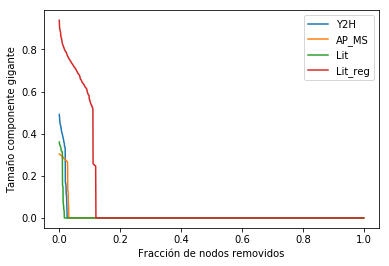

In [431]:
for red in redes_dict.keys():
    start = time.time()
    y = desarme_close(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x, y, label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()